In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import vonmises
import networkx as nx
import torch
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# Elaboración propia

Theta0:[-1.72881021 -2.92461883 -0.20467129  3.01118853  0.75901947]


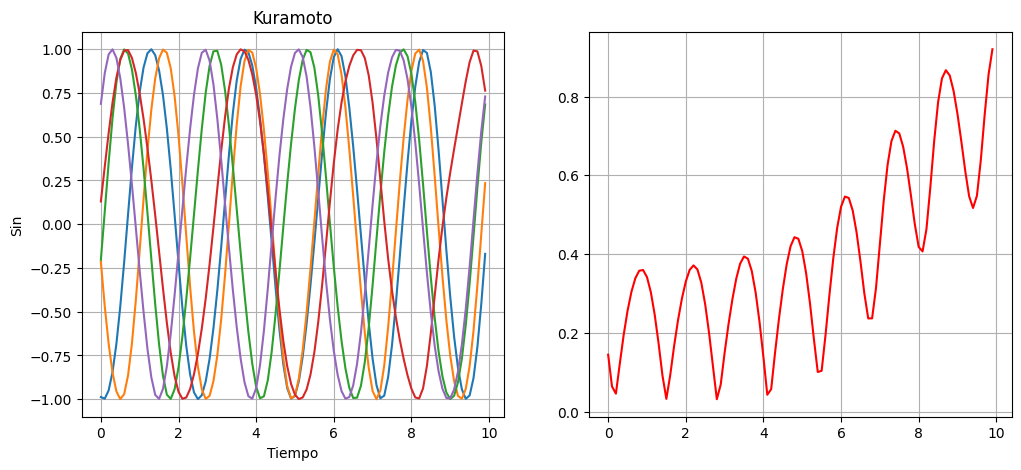

<Figure size 640x480 with 0 Axes>

In [ ]:
#Función
def kuramoto (theta, T, omega, N, K):
  dtheta=np.zeros(N)
  for i in range (N):
    sum= np.sum(np.sin(theta - theta[i]))
    dtheta[i]=  omega[i]  + (K/N)*sum
  return dtheta


#Condiciones
N= 5 #Número de osciladores
K= 1 #constante de acoplamiento
t= 10 #Tiempo máximo
dt=0.1  #Step time
T=np.arange(0, t, dt) #Vector de tiempo

np.random.seed(1)

#¿Cual es el mejor random?

omega = vonmises.rvs(kappa=1.0, loc=np.pi, size=N)  #Para un distribución de dator circulares  (radianes -pi a pi)
theta0 = vonmises.rvs(kappa=1.0, loc=np.pi, size=N)

print(f"Theta0:{theta0}")


sol=odeint(kuramoto, theta0, T, args=(omega,N, K))
sol_norm1=(sol+(2*np.pi)) % (2*np.pi) #Para normlaizar entre 0 y 2 pi
sol_norm = np.where(sol_norm1 > np.pi, sol_norm1 - (2 * np.pi), sol_norm1) #Para normalizar entre -pi y pi

r = np.abs(np.sum(np.exp(1j * sol), axis=1)) / N

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(T, np.sin(sol))
plt.grid()
plt.xlabel('Tiempo')
plt.ylabel(r'Sin')
plt.title('Kuramoto')


plt.subplot(1, 2, 2)
plt.plot(T, r, 'r')
plt.grid()

plt.show()
plt.savefig("kuramoto lineas")

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# Figura
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.axis('on')
ax.set_title("Kuramoto", fontsize=14)

circle = plt.Circle((0, 0), 1, color='gray', fill=False, lw=1)
ax.add_artist(circle)

arrow_line, = ax.plot([], [], color='gray', lw=2)

# Función de actualización
def update(frame):
    theta = sol_norm1[frame]
    x = np.cos(theta)
    y = np.sin(theta)
    # Define colors and points here, using the current data
    cmap = plt.cm.get_cmap('hsv', N)
    colors = [cmap(i) for i in range(N)]

    # Clear previous points, if any
    if ax.collections:
        ax.collections[0].remove()

    points = ax.scatter(x, y, s=80, c=colors)
    r_complex = np.sum(np.exp(1j * theta)) / N
    arrow_line.set_data([0, np.real(r_complex)], [0, np.imag(r_complex)])

    # No need to clear ax.patches as the circle is added once
    #ax.patches.clear()  # This line was causing the error

    return points, arrow_line

ani = FuncAnimation(fig, update, frames=len(T), interval=100, blit=True)


plt.close(fig)

# Mostrar en HTML (Colab)
HTML(ani.to_jshtml())




/tmp/ipython-input-28-458689625.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', N)
/tmp/ipython-input-28-458689625.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', N)


# Con grafos


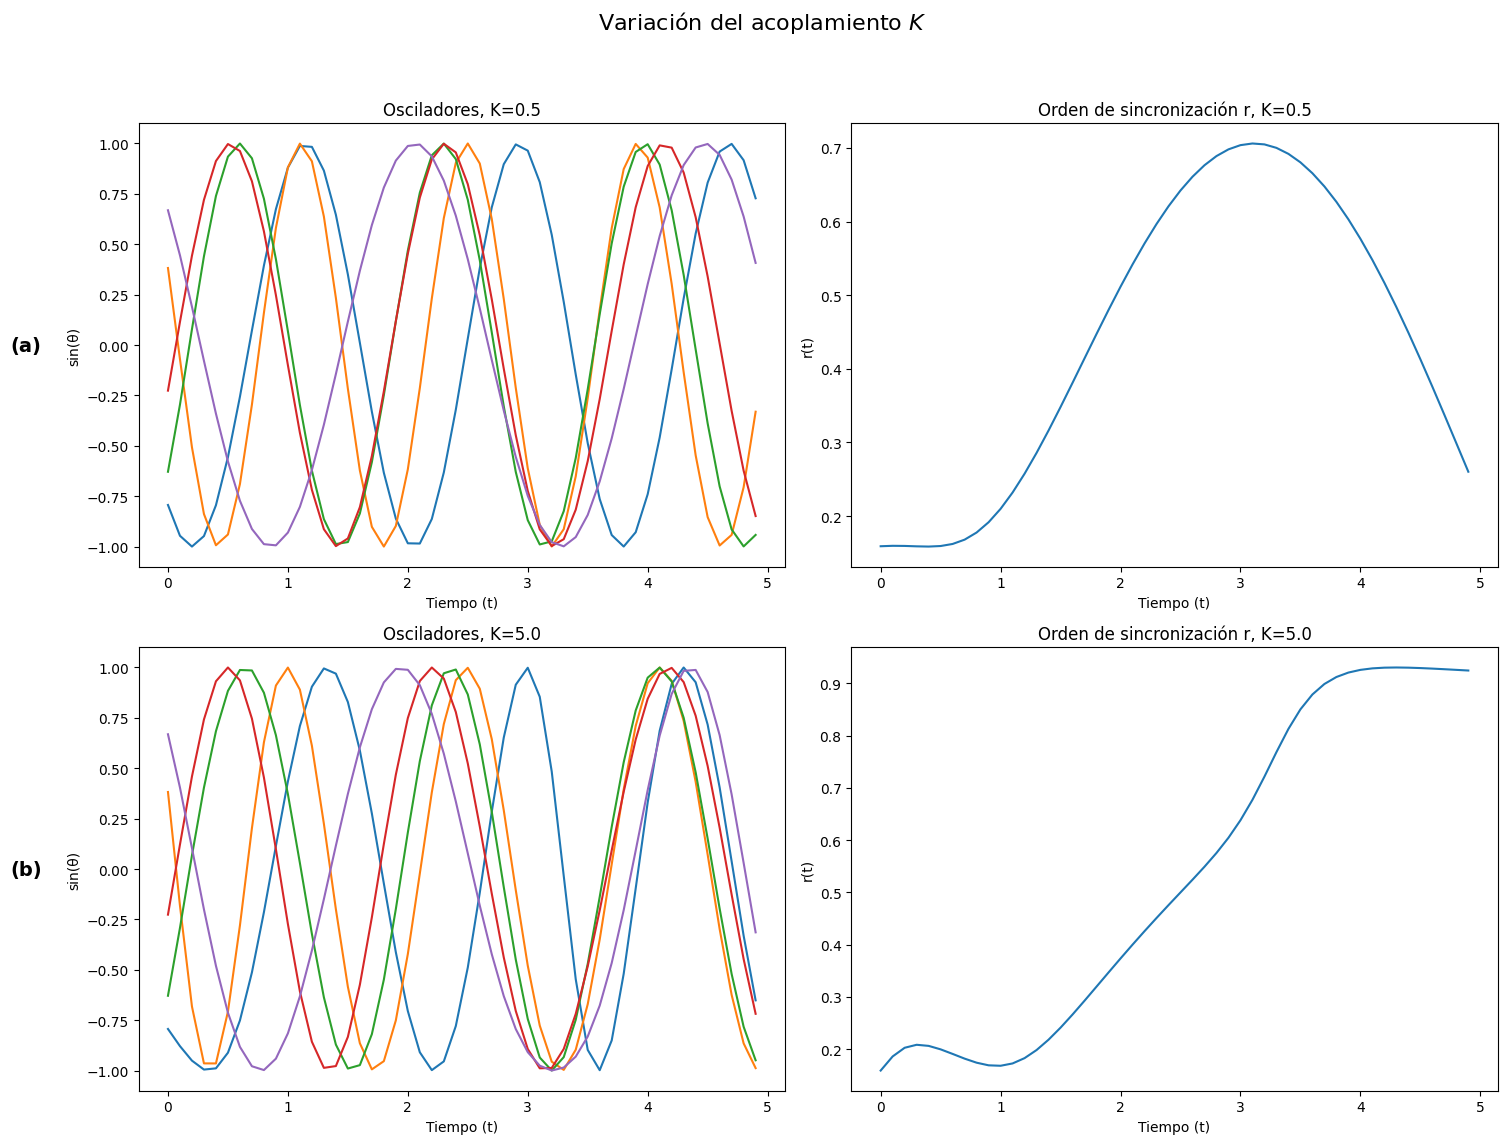

In [ ]:
def interaction (N, p_connect,i):
 if i==1:
  matA=np.zeros([N,N])
  for i in range(N):
   for j in range(N):
     matA[i,j]=np.random.choice([0,1],p=[1-p_connect,p_connect])
     matA[j,i]=matA[i,j]
   matA[i][i]=0
 if i==2:
  G=nx.erdos_renyi_graph(N,p_connect)
  matA=nx.adjacency_matrix(G).todense()
 if i==3:
  G=nx.cycle_graph(N)
  matA=nx.adjacency_matrix(G).todense()
 if i==4:
  G=nx.complete_graph(N)
  matA=nx.adjacency_matrix(G).todense()
 return matA


def kuramoto (theta, T, omega, N, K, matA):
  dtheta=np.zeros(N)
  for i in range (N):
      sum= np.sum(matA[i]*np.sin(theta - theta[i])) #interacción
      dtheta[i]=  omega[i]  + (K/N)*sum
  return dtheta


#------Iniciación--------------------
N=5
t= 5#Tiempo máximo
dt=0.1  #Step time
T=np.arange(0, t, dt) #Vector de tiempo

#Probabilidad de conexión
p_connect=0.5

np.random.seed(0)
omega = np.random.uniform(0, 2*np.pi, N)
theta0 = np.random.uniform(0, 2*np.pi, N)
#Matriz
#i=1: Random
#i=2 erdos
#i=3 cycle
#i=4 complete
#interaction (N, p_connect,i):
matA=interaction(N, p_connect,3)

#-------------------------------------------
valores_K = np.array([0.5,5]) # K = 2, 3, 4, 5
fig, axs = plt.subplots(len(valores_K), 2, figsize=(15, 12))
fig.suptitle('Variación del acoplamiento $K$', fontsize=16)

letras = ['(a)', '(b)', '(c)', '(d)']

for i, Kmod in enumerate(valores_K):
    sol = odeint(kuramoto, theta0, T, args=(omega, N, Kmod, matA))
    r = np.abs(np.sum(np.exp(1j * sol), axis=1)) / N

    # Columna 0: sin(θ)
    axs[i, 0].plot(T, np.sin(sol))
    axs[i, 0].set_title(f"Osciladores, K={Kmod}")
    axs[i, 0].set_ylabel("sin(θ)")
    axs[i, 0].set_xlabel("Tiempo (t)")

    # Etiqueta de fila (a), (b), ...
    axs[i, 0].text(-0.15, 0.5, letras[i], transform=axs[i, 0].transAxes,
                   fontsize=14, fontweight='bold', va='center', ha='right')

    # Columna 1: orden de sincronización r
    axs[i, 1].plot(T, r)
    axs[i, 1].set_title(f"Orden de sincronización r, K={Kmod}")
    axs[i, 1].set_ylabel("r(t)")
    axs[i, 1].set_xlabel("Tiempo (t)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("variacióndeK.pdf")
plt.show()



# Con grilla

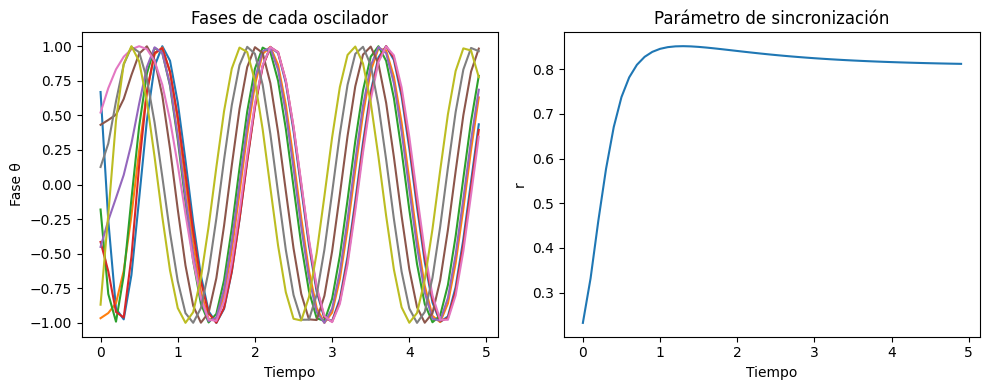

In [ ]:

# Dinámica de Kuramoto
def kuramoto(theta, t, n, omega, matA,K):
    dtheta = np.zeros(n)
    for i in range(n):
        theta_j = np.where(matA[i] == 1, theta, 0)
        sum_term = np.sum(K[i] * np.sin(theta_j - theta[i]))
        dtheta[i] = omega[i] + sum_term
    return dtheta


# Tamaño de la red
N = 3  # Red de 2x2 = 4 nodos
G = nx.grid_2d_graph(N, N)  # Grafo de rejilla
pos = dict((n, n) for n in G.nodes())
matA = nx.to_numpy_array(G)  # Matriz de adyacencia
n = matA.shape[0]  # Número de nodos

K= np.random.uniform(1.0, 5.0, size=(n, n)) * matA  # Solo donde A_ij = 1

# Condiciones iniciales
np.random.seed(0)

omega = np.random.uniform(0, 2*np.pi, n)
theta0 = np.random.uniform(0, 2*np.pi, n)
t= 5#Tiempo máximo
dt=0.1  #Step time
T=np.arange(0, t, dt)

# Solución del sistema
sol = odeint(kuramoto, theta0, T, args=(n, omega, matA,K))

# Medida de sincronización
r = np.abs(np.sum(np.exp(1j * sol), axis=1)) / n

# Graficar fases
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(T, np.sin(sol))
plt.title("Fases de cada oscilador")
plt.xlabel("Tiempo")
plt.ylabel("Fase θ")

# Graficar parámetro de orden
plt.subplot(1, 2, 2)
plt.plot(T, r, label='r(t)')
plt.title("Parámetro de sincronización")
plt.xlabel("Tiempo")
plt.ylabel("r")
plt.tight_layout()

plt.savefig("grilla.pdf")


plt.show()



## Energía

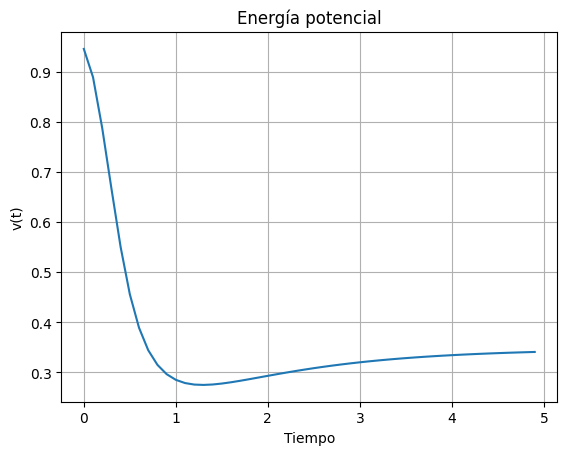

In [ ]:
def calcular_energia(sol):
    n = sol.shape[1]  # número de osciladores
    V = np.zeros(sol.shape[0])  # energía en cada instante de tiempo

    for t_idx, theta in enumerate(sol):
        suma = 0
        for k in range(n):
            for j in range(k+1, n):
                diff = (theta[j] - theta[k]) / 2
                suma += np.sin(diff)**2
        V[t_idx] = (4 / n**2) * suma

    return V

V = calcular_energia(sol)

plt.plot(T, V)
plt.title("Energía potencial")
plt.xlabel("Tiempo")
plt.ylabel("v(t)")
plt.grid(True)


plt.savefig("energia.pdf")
plt.show()


In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.axis('on')
ax.set_title("Kuramoto", fontsize=14)

circle = plt.Circle((0, 0), 1, color='gray', fill=False, lw=1)
ax.add_artist(circle)

arrow_line, = ax.plot([], [], color='gray', lw=2)

# Función de actualización
def update(frame):
    theta = sol[frame]
    x = np.cos(theta)
    y = np.sin(theta)
    # Define colors and points here, using the current data
    cmap = plt.cm.get_cmap('hsv', n)
    colors = [cmap(i) for i in range(n)]

    # Clear previous points, if any
    if ax.collections:
        ax.collections[0].remove()

    points = ax.scatter(x, y, s=80, c=colors)
    r_complex = np.sum(np.exp(1j * theta)) / n
    arrow_line.set_data([0, np.real(r_complex)], [0, np.imag(r_complex)])

    # No need to clear ax.patches as the circle is added once
    #ax.patches.clear()  # This line was causing the error

    return points, arrow_line

ani = FuncAnimation(fig, update, frames=len(T), interval=100, blit=True)


plt.close(fig)

# Mostrar en HTML (Colab)
HTML(ani.to_jshtml())

/tmp/ipython-input-22-2056484297.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', n)
/tmp/ipython-input-22-2056484297.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', n)


## Animación

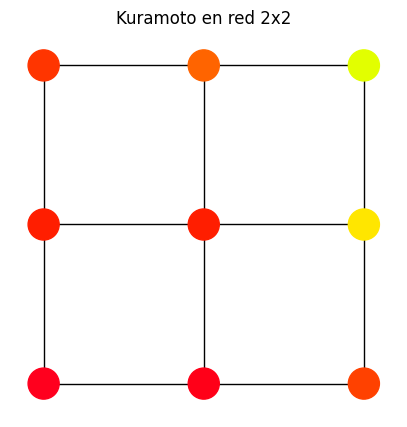

In [ ]:
# Configurar animación
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Kuramoto en red 2x2")
ax.axis("off")

nodes = list(G.nodes())
colors = [plt.cm.hsv(0)] * n
sc = nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax)

def update(frame):
    phases = sol[frame]
    angles = (phases % (2 * np.pi)) / (2 * np.pi)
    node_colors = [plt.cm.hsv(angle) for angle in angles]
    sc.set_color(node_colors)
    return sc,

ani = FuncAnimation(fig, update, frames=len(T), interval=50, blit=True)

# Mostrar video en Colab
HTML(ani.to_jshtml())

# Pruebas sincronicazción

## gpt


In [ ]:
# Configuración
np.random.seed(0)
K = 1.0          # acoplamiento
dt = 0.1         # paso de tiempo
T = 15          # número de pasos

# Frecuencias iniciales (convertidas a radianes)
x = np.random.rand(5, 3)
omega = torch.from_numpy(x * 2 * np.pi).float()  # [5,3]

# Máscara binaria (dónde hay osciladores activos)
num_3 = np.array([
    [1, 1, 1],
    [0, 0, 1],
    [0, 1, 1],
    [0, 0, 1],
    [1, 1, 1]
])
mask = torch.from_numpy(num_3).bool() #True or false

# Estados iniciales: usamos omega como fase inicial θ (solo donde hay oscilador)
theta = omega.clone()

# Vecindades (2D)
def get_neighbors(i, j, shape):
    neighbors = []
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        ni, nj = i + dx, j + dy
        if 0 <= ni < shape[0] and 0 <= nj < shape[1]:
            neighbors.append((ni, nj))
    return neighbors

# Simulación de T pasos
theta_series = [theta.clone()]
for t in range(T):
    dtheta = torch.zeros_like(theta)
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            if not mask[i, j]:  # Si no hay oscilador, lo salteamos
                continue
            neighbors = get_neighbors(i, j, theta.shape)
            acc = 0.0
            count = 0
            for ni, nj in neighbors:
                if mask[ni, nj]:
                    delta = theta[i, j] - theta[ni, nj]
                    acc += torch.sin(delta)
                    count += 1
            K_local = 200.0 if num_3[i, j] == 1 else -1.0  # Asigna K dependiendo de la clase del nodo

            if count > 0:
               dtheta[i, j] = omega[i, j] + (K_local / count) * acc
            else:
              dtheta[i, j] = omega[i, j]
    # Paso de Euler
    theta = theta + dt * dtheta
    theta_series.append(theta.clone())


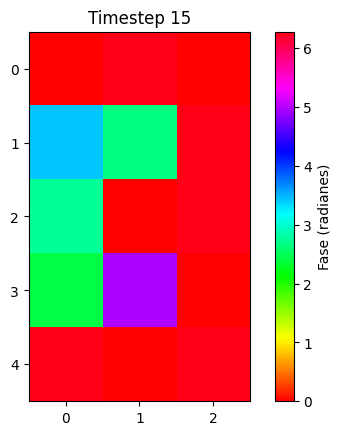

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Crear figura y ejes
fig, ax = plt.subplots()
im = ax.imshow(theta_series[0].numpy(), cmap='hsv', vmin=0, vmax=2*np.pi)
plt.colorbar(im, ax=ax, label="Fase (radianes)")
ax.set_title("Evolución de fases Kuramoto")

# Función para actualizar cada frame
def update(frame):
    im.set_array(theta_series[frame].numpy())
    ax.set_title(f"Timestep {frame}")
    return [im]

# Crear animación
anim = FuncAnimation(fig, update, frames=len(theta_series), interval=200, blit=True)

# Mostrar dentro de Colab
HTML(anim.to_jshtml())

# prueba 2

Para aprender K

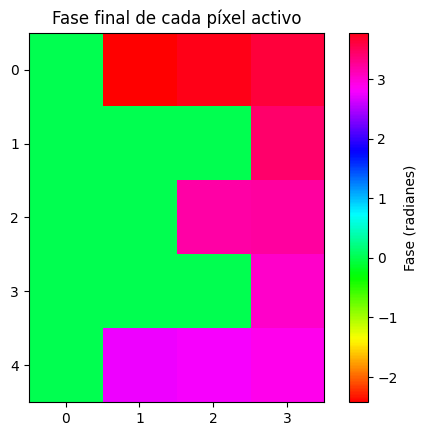

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Imagen binaria del número 3
num_3 = np.array([
    [0, 1, 1,1],
    [0, 0, 0,1],
    [0, 0, 1,1],
    [0, 0, 0,1],
    [0, 1, 1,1]
])

# Tamaño y número de osciladores
H, W = num_3.shape
N = H * W

# Mapeo de (i, j) a índice lineal
def idx(i, j):
    return i * W + j

# Crear matriz de adyacencia (conectividad 4-vecinos)
J = np.zeros((N, N))
for i in range(H):
    for j in range(W):
        if num_3[i, j] == 0:
            continue  # no conectar píxeles de fondo
        index = idx(i, j)
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < H and 0 <= nj < W and num_3[ni, nj] == 1:
                neighbor_index = idx(ni, nj)
                J[index, neighbor_index] = 1

# Inicializar fases aleatorias solo para píxeles activos
theta = np.random.uniform(0, 2*np.pi, N)
omega = np.zeros(N)  # sin frecuencia interna
mask = num_3.flatten() == 1

# Parámetros de simulación
T = 100
dt = 0.1
theta_history = []

for t in range(T):
    dtheta = np.zeros(N)
    for i in range(N):
        if not mask[i]:
            continue
        interactions = J[i] * np.sin(theta - theta[i])
        dtheta[i] = omega[i] + np.sum(interactions)
    theta += dt * dtheta
    theta_history.append(theta.copy())

theta_history = np.array(theta_history)

# Visualizar sincronización por color final
final_phases = theta_history[-1]
phase_image = np.zeros(N)
phase_image[mask] = final_phases[mask]
phase_image = phase_image.reshape(H, W)

plt.imshow(phase_image, cmap='hsv')
plt.title('Fase final de cada píxel activo')
plt.colorbar(label='Fase (radianes)')
plt.show()
